## **Generating Image Descriptions: Aid for the Visually Impaired**

Priyanka Shishodia (ps4118)

In [1]:
!pip install -q tqdm

In [31]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pickle
from pickle import dump, load
import time
import os

import torch
import tensorflow as tf
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.preprocessing import image


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
  device = 'cuda'
else:
  device = 'cpu'

print('Device: ', device)

Device:  cuda


### **1. Data Preprocessing and Cleaning**

In [6]:
# Function to load the file and read its text
def load_caption(filename):
  file = open(filename, 'r')
  read_text = file.read()
  file.close()
  return read_text

# Cleaning captions - Removing punctuation, converting to lowercase, single-character words and numeric values
def clean_text(text):
  caption = text.lower()
  translator = str.maketrans('', '', string.punctuation) # Removes punctuation using the translator method defined below
  caption = caption.translate(translator)

  desc_list = ""
  for word in caption.split():
    if len(word) >= 1 and word.isdigit() == False:
      desc_list += " " + word

  caption = desc_list
  return caption


# Creating a dataframe from the text files
def create_dataframe(text):
  data = []
  descriptions = {}    # Dictionary with image as the key and a list of all the five captions as value
  for sentence in text.split('\n'):
    splits = sentence.split('\t')

    if len(splits) != 1:
      idx = splits[0].split('#')
      data.append(idx + [splits[1].lower()])
      img_idx = idx[0].split('.')[0]
      text = splits[1]
      caption = clean_text(text)    # Cleaning text using the function defined 
      
      if img_idx not in descriptions.keys():
        descriptions[img_idx] = list()     
      descriptions[img_idx].append(caption)

    else:
      continue
  return data, descriptions


#### An example of raw data - Image ID with caption number and assoiated captions

#### The text file contains raw captions for the Dataset. The first column denotes the image ID with the caption number (0 - 4)

In [7]:
text = load_caption('/content/gdrive/MyDrive/Deep_Learning/Flickr8k_text/Flickr8k.token.txt')
print(text[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [8]:
data, dictionary = create_dataframe(text)
df = pd.DataFrame(data, columns=['image', 'index', 'caption'])
images_vector = np.unique(df.image.values)
print('Number of unique images (datapoints): ', len(images_vector))
df.head(5)

Number of unique images (datapoints):  8092


,image,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...


#### A dictionary key as Image ID and its 5 captions

In [9]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
df.caption.values[:15]

array(['a child in a pink dress is climbing up a set of stairs in an entry way .',
       'a girl going into a wooden building .',
       'a little girl climbing into a wooden playhouse .',
       'a little girl climbing the stairs to her playhouse .',
       'a little girl in a pink dress going into a wooden cabin .',
       'a black dog and a spotted dog are fighting',
       'a black dog and a tri-colored dog playing with each other on the road .',
       'a black dog and a white dog with brown spots are staring at each other in the street .',
       'two dogs of different breeds looking at each other on the road .',
       'two dogs on pavement moving toward each other .',
       'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
       'a little girl is sitting in front of a large painted rainbow .',
       'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
       'there is a girl with

#### Preprocessing images for the InceptionV3 model
1. Resizing the images to 299 x 299
2. Using keras process_input method to normalize the pixel values between -1 to 1

In [10]:
def load_image_preprocess(img_path):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels = 3)
  img = tf.image.resize(img, (299, 299))  # Resizing the image to 299 * 299

  # Preprocessing the input using preprocess_input method: Normalizing the pixel values between -1 t0 1
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, img_path

# Method to create a list of image paths
def create_images_vector(images_vector, root):
  paths = []
  for img in images_vector:
    paths.append(root + img)
  return paths

root = '/content/gdrive/MyDrive/Deep_Learning/Flickr8k_Dataset/Flicker8k_Dataset/' 
list_image_paths = create_images_vector(images_vector, root)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(299, 299, 3)


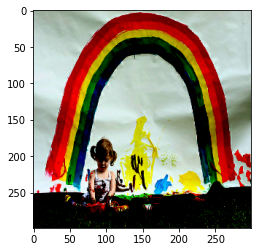

In [ ]:
demo_img, img_path = load_image_preprocess(root + images_vector[2])
plt.imshow(demo_img)
print(demo_img.shape)

In [11]:
# Additional code to remove a non-existing training data image present in our text file

find = '/content/gdrive/MyDrive/Deep_Learning/Flickr8k_Dataset/Flicker8k_Dataset/2258277193_586949ec62.jpg.1'
for i, val in enumerate(list_image_paths):
  if find == val:
    print(i, val)
    list_image_paths[i] = root + '2258277193_586949ec62.jpg'

del list_image_paths[1346]

1346 /content/gdrive/MyDrive/Deep_Learning/Flickr8k_Dataset/Flicker8k_Dataset/2258277193_586949ec62.jpg.1


#### Splitting train, validate and test data

In [36]:
# Creating separate train, validate and test image lists
train_images_path = '/content/gdrive/MyDrive/Deep_Learning/Flickr8k_text/Flickr_8k.trainImages.txt'
train_text = open(train_images_path, 'r').read().strip().split('\n')
train_images = create_images_vector(train_text, root)

test_images_path = '/content/gdrive/MyDrive/Deep_Learning/Flickr8k_text/Flickr_8k.testImages.txt'
test_txt = open(test_images_path, 'r').read().strip().split('\n')
test_images = create_images_vector(test_txt, root)

validate_images_path = '/content/gdrive/MyDrive/Deep_Learning/Flickr8k_text/Flickr_8k.devImages.txt'
validate_images = open(validate_images_path, 'r').read().strip().split('\n')
validate_images = create_images_vector(validate_images, root)

print('Length of train, validate and test data: ', len(train_images), len(validate_images), len(test_images))

Length of train, validate and test data:  6000 1000 1000


#### Preprocessing captions for the decoder model

In [37]:
# Loading captions in a dictionary only for the training images
train_dictionary = {}
test_dictionary = {}   # Implementing for later BLEU Analysis

# Adding <start> and <end> tokens --- decide either to all_captions list or dictionary 
for key in dictionary.keys():
  key_updated = key + '.jpg'
  if key_updated in train_text:
    train_dictionary[key] = list()

    for c in dictionary[key]:
      caption = '<start>' + ''.join(c) + ' <end>'
      train_dictionary[key].append(caption)
  
  if key_updated in test_txt:
    test_dictionary[key] = list()

    for c in dictionary[key]:
      test_dictionary[key].append(c)

#### Defining utility functions for Captions processing

In [14]:
# A list of all the captions in the dataframe
def create_captions_list(dictionary):
  all_captions = []
  for key in dictionary.keys():
    for c in dictionary[key]:
      all_captions.append(c)
  return all_captions

def max_length(captions):
  lengths = []
  for caption in captions:
    lengths.append(len(caption.split()))
  return max(lengths)

In [15]:
# Creating a Vocabulary of all the unique tokens in the corpus
vocab = set()
train_all_captions = create_captions_list(train_dictionary)
max_caption = max_length(train_all_captions)

for key in train_dictionary.keys():
  [vocab.update(caption.split()) for caption in train_dictionary[key]]
print('Original Vocabulary size: ', len(vocab))

# Consider only words which occur at least 10 times in the corpus
threshold = 10
counts = {}
num_sentence = 0
for sent in train_all_captions:
    num_sentence += 1
    for token in sent.split(' '):
        counts[token] = counts.get(token, 0) + 1

vocab = [word for word in counts if counts[word] >= threshold]
print('Vocabulary size after removing low frequency words: ', len(vocab))
print('Maximum length of a caption in the corpus is: ', max_caption)

Original Vocabulary size:  7597
Vocabulary size after removing low frequency words:  1654
Maximum length of a caption in the corpus is:  37


In [16]:
# Python dictionaries to map tokens to index 
token_to_idx, idx_to_token = {}, {} 

index = 1
for token in vocab:
  token_to_idx[token] = index
  idx_to_token[index] = token
  index += 1

print(f"Index of <start> token is {token_to_idx['<start>']} and <end> token is {token_to_idx['<end>']}")

Index of <start> token is 1 and <end> token is 15


### **2. GLoVe embeddings**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-05-18 19:23:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-18 19:23:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-18 19:23:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# Using Keras pre-trained GLOVE word-embeddings (dimension: 200)

path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.200d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [20]:
embeddings_size = 200
vocab_size = len(vocab) + 1

In [ ]:
embeddings = np.zeros((vocab_size, embeddings_size))

for token, idx in tqdm(token_to_idx.items()):
  if token in embeddings_index:
    vector = embeddings_index[token]
    embeddings[idx] = vector

100%|██████████| 1654/1654 [00:00<00:00, 309345.35it/s]


Checkpoint: Saving the embeddings matrix

In [34]:
print('Size of embeddings matrix: ', embeddings.shape)
with open('/content/gdrive/MyDrive/Deep_Learning/Saved_files/embeddings.pkl', 'wb') as embeddings_file:
  pickle.dump(embeddings, embeddings_file)

with open('/content/gdrive/MyDrive/Deep_Learning/Saved_files/token_to_idx.pkl', 'wb') as token_idx_file:
  pickle.dump(token_to_idx, token_idx_file)

with open('/content/gdrive/MyDrive/Deep_Learning/Saved_files/idx_to_token.pkl', 'wb') as idx_token_file:
  pickle.dump(idx_to_token, idx_token_file)

Size of embeddings matrix:  (1655, 200)


### **3. Encoder: InceptionV3 model**
> Creating an instance of the InceptionV3 architecture pretrained on ImageNet

> Extracting the feature vector from the last convolutional layer of shape (8 x 8 x 2048): Parameter include_top set to False

#### Method 1: Feature Extraction (without tensorFlow's parallel computation)

In [ ]:
# Fit the encoder model to the training and validation dataset
model = InceptionV3(weights = 'imagenet')
model_new = Model(model.input, model.layers[-2].output)

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(x)
    return x

In [ ]:
features_dict = {}

start = time.time()
for img_path in tqdm(test_images):
  pre_img = preprocess(img_path)
  features = model_new(pre_img)
  features = np.reshape(features, features.shape[1])

  features_dict[img_path] = features

end = time.time()
print('Time taken to generate features vector (train data): ', (end - start)/60)

#### Method 2: Feature Extraction (with TensorFLow's batch processing)

In [ ]:
encoder_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = encoder_model.input 
hidden_layer = encoder_model.layers[-1].output
encoder_features_model = tf.keras.Model(new_input, hidden_layer)

encoder_features_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Extracting features from the encoder model and caching it 
# Creating a dataset of tensors from the train images list
images_data = tf.data.Dataset.from_tensor_slices(train_images)

# Mapping the preprocess method on the dataset and paralellizing it (num of batches: 64)
images_data = images_data.map(load_image_preprocess, num_parallel_calls = tf.data.AUTOTUNE).batch(64)
features_dict = {}

start = time.time()
for img, filepath in tqdm(images_data):
  features = encoder_features_model(img)
  features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))

  for f, path in zip(features, filepath):
    features_path = path.numpy().decode('utf-8')
    np.save(features_path, f.numpy())
    features_dict[features_path] = f.numpy()
    
end = time.time()

In [ ]:
print('Time taken to generate features vector (train data): ', (end - start)/60)

Time taken to generate features vector (train data):  28.365445109208427


Checkpoint: The code snippet below is to save the features_dict generated by the IncpetionV3 model once. These image features of length 2048, would be used for in the decoder LSTM-model


In [ ]:
# Saving the train and test features dictionary
from pickle import dump, load
with open('/content/gdrive/MyDrive/Deep_Learning/Saved_files/train_features.pkl', 'wb') as features_file:
  pickle.dump(features_dict, features_file)

from pickle import dump, load
with open('/content/gdrive/MyDrive/Deep_Learning/Saved_files/test_features.pkl', 'wb') as features_file:
  pickle.dump(features_dict, features_file)

### **4. LSTM Decoder**

The following function is used to format the data needed to input to the Deep Learning decoder model. 

> Caption: Consider the caption '(start) a child in a pink dress is climbing up a set of stairs in an entry way (end)' and a features_vector generated by the InceptionV3 model.

> The function converts it into the input format:

*   features_vector + '(start)'
*   features_vector + '(start) a'
*   features_vector + '(start) a child'
*   features_vector + '(start) a child in'

... and so on.





In [17]:
root_dir = '/content/gdrive/MyDrive/Deep_Learning/Flickr8k_Dataset/Flicker8k_Dataset/'   

def decoder_data_generator(dictionary, features_dict, token_to_idx, max_caption, images_batch_size):
  X1, X2, y = list(), list(), list()
  n=0
  while 1:
    for key, desc_list in dictionary.items():
      n+=1

      image = features_dict[root_dir + key + '.jpg']
      for desc in desc_list:
        # encoding the input caption
        seq = [token_to_idx[word] for word in desc.split(' ') if word in token_to_idx]  
        
        for i in range(1, len(seq)):  
          in_seq, out_seq = seq[:i], seq[i]  
          in_seq = keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_caption)[0]  

          # Encoding the output caption          
          out_seq = keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]  
          X1.append(image)
          X2.append(in_seq)
          y.append(out_seq)
            
      if n == images_batch_size:   # yield the batch data
        yield [np.array(X1), np.array(X2)], np.array(y)
        X1, X2, y = list(), list(), list()
        n=0

In [18]:
def decoder_model():

   input_1 = keras.Input(shape=(2048,)) 
   dropout_1 = keras.layers.Dropout(0.5)(input_1)
   dense_1 = keras.layers.Dense(256, activation = 'relu')(dropout_1)

   input_2 = keras.Input(shape=(max_caption,))
   embeddings_layer = keras.layers.Embedding(vocab_size, embeddings_size, mask_zero = True)(input_2)
   dropout_2 = keras.layers.Dropout(0.5)(embeddings_layer)
   lstm_layer = keras.layers.LSTM(256)(dropout_2)

   add_1 = keras.layers.merge.add([dense_1, lstm_layer])
   dense_2 = keras.layers.Dense(256, activation = 'relu')(add_1)
   output_layer = keras.layers.Dense(vocab_size, activation = 'softmax')(dense_2)
   model = keras.models.Model(inputs = [input_1, input_2], outputs = output_layer)
   
   return model

In [21]:
LSTM_decoder = decoder_model()
LSTM_decoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 200)      331000      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_3[0][0]                    
______________________________________________________________________________________________

#### Defining LSTM decoder loss and optimizer and setting embeddings weights

In [24]:
embeddings = load(open('/content/gdrive/MyDrive/Deep_Learning/Saved_files/embeddings.pkl', 'rb'))
features_dict = load(open('/content/gdrive/MyDrive/Deep_Learning/Saved_files/train_features.pkl', 'rb'))

LSTM_decoder.layers[2].set_weights([embeddings])
LSTM_decoder.layers[2].trainable = False

LSTM_decoder.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001))

def model_parameters(model, embeddings):
  embeddings_layer = model.layers[2]
  embeddings_layer.set_weights([embeddings])
  embeddings_layer.trainable = False
  model.layers[2] = embeddings_layer

  model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001))
  return model

LSTM_decoder = model_parameters(LSTM_decoder, embeddings)

In [26]:
epochs = 30
images_per_batch = 6
steps = len(train_dictionary)//images_per_batch

for i in range(epochs):
    generator = decoder_data_generator(train_dictionary, features_dict, token_to_idx, max_caption, images_per_batch)
    LSTM_decoder.fit_generator(generator, epochs=1, steps_per_epoch = steps, verbose=1)
    LSTM_decoder.save('/content/gdrive/MyDrive/Deep_Learning/Saved_files/models/model_' + str(i) + '.h5')


   1/1000 [..............................] - ETA: 1:41 - loss: 3.2640

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1000/1000 [==============================] - 101s 101ms/step - loss: 2.0817


In [33]:
LSTM_decoder.save('/content/gdrive/MyDrive/Deep_Learning/Saved_files/models/trained_model' + '.h5')